<a href="https://colab.research.google.com/github/ian-byrne/MADSmilestone2/blob/main/Supervised_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Supervised Learning: Clock Drawing Image Classification with Convolutional Neural Networks
### Stacey Beck and Ian Byrne

- Split data into sets of Training (x = image arrays ; y = labels), Test (~10% image arrays), and Validation (~10% of the Training). 
- Build CNN using Pytorch for Training and Test:
  - Specify CUDA
  - 2D convolution, Normalization (for faster training), Non-linear Activation Function (ex. RELU), Max Pooling (downsampling to reduce learned parameters).
  - Define Layers 
  - Build Forward and backward pass
  - Define optimizer (due to many - deep - nodes) ex) ADAM
  - Calculate Loss (BCE)
  - Calculate Accuracy, Precision, Recall (Confusion Matrix)
  - Plot ROC and print Confusion Matrix



In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# Clone the entire repo.
!git clone -l -s https://github.com/ian-byrne/MADSmilestone2.git

# Change directory into cloned repo
%cd MADSmilestone2

# List repo contents
#!ls

Cloning into 'MADSmilestone2'...
remote: Enumerating objects: 574, done.
remote: Counting objects: 100% (574/574), done.
remote: Compressing objects: 100% (473/473), done.
remote: Total 574 (delta 318), reused 219 (delta 92), pack-reused 0
Receiving objects: 100% (574/574), 4.21 MiB | 6.36 MiB/s, done.
Resolving deltas: 100% (318/318), done.
/content/MADSmilestone2


In [3]:
!pip install torchmetrics

# General Libraries
import pandas as pd
import numpy as np

# Custom Libraries
import Loading.load_data as ld
import ImagePlayground.Images

# Pytroch Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

# To Evaluate model
from tqdm import tqdm
import torchmetrics
from torchmetrics import ConfusionMatrix
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# To visualize model
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from skimage.io import imread

# To split the data
from sklearn.model_selection import train_test_split

     |████████████████████████████████| 282 kB 14.9 MB/s 


In [ ]:
#!rm -rf /content/MADSmilestone2

# Build CNN Model using Pytorch


### Building and Training
Architecture choices influenced from: 

https://www.analyticsvidhya.com/blog/2018/12/guide-convolutional-neural-network-cnn/

https://medium.datadriveninvestor.com/five-powerful-cnn-architectures-b939c9ddd57b

https://towardsdatascience.com/how-does-sparse-convolution-work-3257a0a8fd1

In [4]:
# Define some of the hyperparameters and training variables
#epochs = 2
batch_size = 25
learning_rate = .001
kernel_size = 3
stride = 1
padding = 1 #2*floor(3/2)
#activation function

In [5]:
# Load numpy array files, add dimension of 1 for gray scale, and zip images and labels 
# get zipped im label and separate label tensors
tr_im_path = "Dementia_label_data/balanced_training.npy"
tr_lb_path = "Dementia_label_data/balanced_train_labels.npy"
val_im_path = "Dementia_label_data/val_im_nobal.npy"
val_lb_path = "Dementia_label_data/val_labels_im_nobal.npy"
tst_im_path = "Dementia_label_data/test_im_nobal.npy"
tst_lb_path = "Dementia_label_data/val_labels_im_nobal.npy"

training_data, y_train_tensor = ld.load_np_files(tr_im_path, tr_lb_path)
#validation_data, y_val_tensor = ld.load_np_files(val_im_path, val_lb_path)
test_data, y_test_tensor = ld.load_np_files(tst_im_path, tst_lb_path)


(23535, 1, 368, 284)
(2541, 1, 368, 284)


In [6]:
# Get image data and label tensors
train_loader = torch.utils.data.DataLoader(training_data, batch_size = batch_size, shuffle = True) 
#validate_loader = torch.utils.data.DataLoader(validation_data, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle = True)


#Labels 
classes = (0, 1, 2)

torch.LongTensor
torch.Size([4, 1, 368, 284])


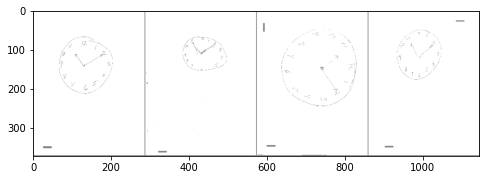

Labels:
    2              2              0              0


In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(8,10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
#print(images.size())
print(images.type())
#images = images.unsqueeze(1)
print(images.size())
# show images
imshow(torchvision.utils.make_grid(images, nrow = 4))
# print labels
print('Labels:')
print('          '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

#Printing as RGB, just using basic pytorch dataloader likely converting to rbg

CUDA is available! Training on GPU...
available


  0%|          | 0/20 [00:00<?, ?it/s]

[1 1] loss 0.0022
[1 501] loss 1.0786

Finished training Epoch 1



  5%|▌         | 1/20 [01:10<22:10, 70.04s/it]

Accuracy = 24.911452184179456
[2 1] loss 0.0021
[2 501] loss 0.9860

Finished training Epoch 2



 10%|█         | 2/20 [02:14<19:56, 66.49s/it]

Accuracy = 36.599763872491145
[3 1] loss 0.0016
[3 501] loss 0.7521

Finished training Epoch 3



 15%|█▌        | 3/20 [03:18<18:30, 65.34s/it]

Accuracy = 41.83392365210547
[4 1] loss 0.0009
[4 501] loss 0.4379

Finished training Epoch 4



 20%|██        | 4/20 [04:21<17:16, 64.79s/it]

Accuracy = 49.39000393545848
[5 1] loss 0.0006
[5 501] loss 0.1895

Finished training Epoch 5



 25%|██▌       | 5/20 [05:26<16:07, 64.53s/it]

Accuracy = 40.85005903187721
[6 1] loss 0.0003
[6 501] loss 0.0629

Finished training Epoch 6



 30%|███       | 6/20 [06:30<15:02, 64.45s/it]

Accuracy = 40.92876820149547
[7 1] loss 0.0001
[7 501] loss 0.0286

Finished training Epoch 7



 35%|███▌      | 7/20 [07:34<13:56, 64.33s/it]

Accuracy = 38.52813852813853
[8 1] loss 0.0000
[8 501] loss 0.0112

Finished training Epoch 8



 40%|████      | 8/20 [08:38<12:51, 64.26s/it]

Accuracy = 40.023612750885476
[9 1] loss 0.0000
[9 501] loss 0.0072

Finished training Epoch 9



 45%|████▌     | 9/20 [09:42<11:46, 64.22s/it]

Accuracy = 41.99134199134199
[10 1] loss 0.0000
[10 501] loss 0.0028

Finished training Epoch 10



 50%|█████     | 10/20 [10:46<10:41, 64.16s/it]

Accuracy = 40.22038567493113
[11 1] loss 0.0000
[11 501] loss 0.0010

Finished training Epoch 11



 55%|█████▌    | 11/20 [11:50<09:37, 64.14s/it]

Accuracy = 40.65328610783156
[12 1] loss 0.0000
[12 501] loss 0.0005

Finished training Epoch 12



 60%|██████    | 12/20 [12:54<08:32, 64.09s/it]

Accuracy = 41.086186540731994
[13 1] loss 0.0000
[13 501] loss 0.0004

Finished training Epoch 13



 65%|██████▌   | 13/20 [13:58<07:28, 64.05s/it]

Accuracy = 40.85005903187721
[14 1] loss 0.0000
[14 501] loss 0.0003

Finished training Epoch 14



 70%|███████   | 14/20 [15:02<06:24, 64.03s/it]

Accuracy = 40.53522235340417
[15 1] loss 0.0000
[15 501] loss 0.0003

Finished training Epoch 15



 75%|███████▌  | 15/20 [16:06<05:20, 64.02s/it]

Accuracy = 40.65328610783156
[16 1] loss 0.0000
[16 501] loss 0.0002

Finished training Epoch 16



 80%|████████  | 16/20 [17:10<04:16, 64.02s/it]

Accuracy = 40.456513183785916
[17 1] loss 0.0000
[17 501] loss 0.0002

Finished training Epoch 17



 85%|████████▌ | 17/20 [18:14<03:12, 64.02s/it]

Accuracy = 40.456513183785916
[18 1] loss 0.0000
[18 501] loss 0.0002

Finished training Epoch 18



 90%|█████████ | 18/20 [19:18<02:08, 64.02s/it]

Accuracy = 40.41715859897678
[19 1] loss 0.0000
[19 501] loss 0.0002

Finished training Epoch 19



 95%|█████████▌| 19/20 [20:22<01:04, 64.01s/it]

Accuracy = 40.181031090122
[20 1] loss 0.0000
[20 501] loss 0.0001

Finished training Epoch 20



100%|██████████| 20/20 [21:26<00:00, 64.34s/it]

Accuracy = 40.25974025974026


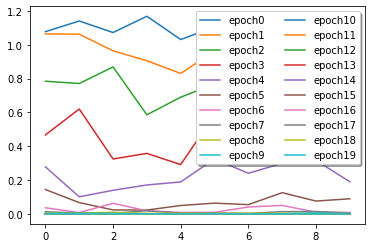

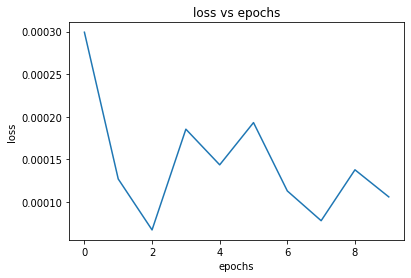

In [8]:
# Set to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#torch.backends.cudnn.benchmark = True




class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()
    # without considering batch size: Input shape : (None,368, 284, 1) , parameters: (3*3*1*16+16) = 160
    self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 16, # one input channel gray scale, 16 filters out
                            kernel_size = 3, stride = 1, padding = 1) #Out:(None,386, 284, 16)

    #Normalize each output to help w/ faster learning                       
    self.bn1 = nn.BatchNorm2d(16)
    self.pool1 = nn.MaxPool2d(2, 2) #Out: (None, 184, 142, 16)
    self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 32, 
                          kernel_size = 3, stride = 1, padding = 1) #params: (3*3*16*32+32) = 4640    
    self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 32, 
                          kernel_size = 3, stride = 1, padding = 1) # params: (3*3*32*32+32) = 9248                     
    self.bn2 = nn.BatchNorm2d(32) 
    self.pool2 = nn.MaxPool2d(2, 2) #Output shape = (None, 92, 71, 32)
                            
    # Flatten
    self.fc1 = nn.Linear(32*92*71,120)
    self.fc2 = nn.Linear(120, 30)
    self.fc3 = nn.Linear(30, 3) # left with 3 for the three classes






  def forward(self, x):
    x = self.pool1(self.bn1(F.relu(self.conv1(x))))
    x = self.pool2(self.bn2(F.relu(self.conv3(F.relu(self.conv2(x))))))
    x = x.view(x.size(0),32*92*71)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)

    return x



train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    print("CUDA is available! Training on GPU...")
else:
    print("CUDA is not available. Training on CPU...")


# Create model object 
model = ConvNet().to(float).to(device)
if torch.cuda.is_available():
    model.cuda()
    print('available')

#for param in model.parameters():
  #print(str(param.data.numpy().shape)+'\n')
  #print("weights fc1: ", model.fc1.weight)
  #print("weights fc3: ", model.fc3.weight)

# Loss function
criterion = nn.CrossEntropyLoss().to(device)

#Optimizer (can use SGD or ADAM)
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)#, momentum = 0.9) #or ADAM/ momentum
acc = 0 # accuracy
#epoch = 0 # training episodes
n_total_steps = len(train_loader) 






def train_model(epochs):
  # set model in training mode (recommended)
  model.train()
  for epoch in tqdm(range(epochs)):
    losses = []
    running_loss = 0.0
    num_times = 0
    for i, (images, labels) in enumerate(train_loader, 0):
      images = images.to(float).to(device) # for GPU support
      labels = labels.to(device) 

      # sets gradients to 0 to prevent interference with previous epoch
      optimizer.zero_grad()

      # Forward pass through NN
      outputs = model(images.to(float))
      loss = criterion(outputs, labels)

      # Backward pass, updating weights
      loss.backward()
      optimizer.step()
      #print(model.fc1.weight.detach().numpy())

      # Statistics 
      running_loss += loss.item()
      # Track every 100th loss:
      if i % 100 == 0:
        losses.append(loss.item())
        num_times = num_times + 1

      # print every 500th batch
      if i % 500 == 0:
        #print("epoch: {} loss: {}".format(i, loss))
        print('[%d %d] loss %.4f'% (epoch + 1, i + 1, running_loss/500))
        running_loss = 0.0

    print("\nFinished training Epoch {}\n".format(epoch + 1))
    # Calculate the accuracy and save the model state  
    accuracy()

    # Plot the loss
    plt.plot([i for i in range(num_times)],losses, label = 'epoch' + str(epoch))
    plt.legend(loc = 1, mode = 'expanded', shadow = True, ncol = 2)
  plt.show()

  los_chart(losses)







def los_chart(losses):
  plt.plot(losses)
  plt.title('loss vs epochs')
  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.show()








def accuracy():
  model.eval()
  # Calculate performance
  correct = 0
  total = 0
  accuracy = 0
  with torch.set_grad_enabled(False):
      #model.to(float)
      for batches in test_loader:
        x_test, y_test = batches
        x_test = x_test.to(float).to(device)
        y_test = y_test.to(float).to(device)
        y_pred = model(x_test)
        _,y_pred = torch.max(y_pred.data, 1)# returns strongest label val and index
        total += y_test.size(0)
        #print(y_pred.size())
        #print(y_test.size())
      
        correct += (y_pred == y_test).sum().item()
        accuracy = (correct/total) * 100
      
      
      print('Accuracy = '+str(accuracy))















if __name__ == '__main__':
  train_model(20)













## Create Confusion Matrix

torch.Size([23535, 3])
torch.Size([2544])
torch.Size([10])
torch.Size([23535])


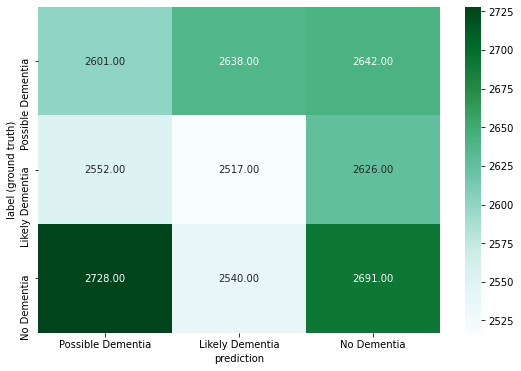

              precision    recall  f1-score   support

           0       0.33      0.33      0.33      7881
           1       0.33      0.33      0.33      7695
           2       0.34      0.34      0.34      7959

    accuracy                           0.33     23535
   macro avg       0.33      0.33      0.33     23535
weighted avg       0.33      0.33      0.33     23535



In [9]:
def conf_matrix(model, loader):
  model.eval()
  all_preds = torch.tensor([])
  with torch.set_grad_enabled(False):
    for batch in loader:
      x_test, y_test = batch
      x_test = x_test.to(float).to(device)
      y_test = y_test.to(float).to(device)
      preds = model(x_test)
      # concatenates all predictions per batch into one list
      all_preds = torch.cat((all_preds.cpu(), preds.cpu()),dim = 0) 
  
  print(all_preds.size())
  print(y_test_tensor.size())
  print(y_test.size())
  print(y_train_tensor.size())
  return all_preds






def plot_conf_matrix(matrix, class_names, session):
  df_cm = pd.DataFrame(matrix.numpy(), class_names, class_names)
  df_cm.to_csv("/content/gdrive/MyDrive/Colab Notebooks/model_charts/conf_matrix_{}".format(session))
  plt.figure(figsize = (9,6))
  sns.heatmap(df_cm, annot=True, fmt=".2f", cmap='BuGn')
  plt.xlabel("prediction")
  plt.ylabel("label (ground truth)")
  plt.show()







all_pred = conf_matrix(model, train_loader)
confmat = ConfusionMatrix(num_classes = 3)
cmtx = confmat(all_pred, y_train_tensor)
class_names = ["Possible Dementia", "Likely Dementia", "No Dementia"]
class_vals = [0,1,2]
plot_conf_matrix(cmtx, class_names, 1)
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_train_tensor, all_pred.argmax(axis=1), class_vals))

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_train_tensor, all_pred.argmax(axis=1), class_vals))

              precision    recall  f1-score   support

           0       0.33      0.33      0.33      7881
           1       0.33      0.33      0.33      7695
           2       0.34      0.34      0.34      7959

    accuracy                           0.33     23535
   macro avg       0.33      0.33      0.33     23535
weighted avg       0.33      0.33      0.33     23535



## Save the GPU CNN Model
Also includes loading on GPU

In [11]:
# Save GPU model
model_name = 'model_cnn.checkpoint2'
PATH = "/content/gdrive/MyDrive/Colab Notebooks/Models/{}".format(model_name)
torch.save(model.state_dict(), PATH)

In [ ]:
# Load GPU model
device = torch.device("cuda")
model = TheModelClass(*args, **kwargs)
model.load_state_dict(torch.load(PATH))
model.to(device)

In [ ]:
# Calculate a Confusion Matrix of all the data
train_preds = get_all_preds(model, train_loader)
preds_correct = get_num_correct(train_preds, y_train_tensor)
print("total correct: ", preds_correct)
print("Accuracy_p: ", (preds_correct/len(training_data))*100)

total correct:  27692
Accuracy_p:  67.39516658959819
